In [0]:
#setup
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, round, sum, avg, datediff, current_date, when, format_number,to_date,lit
from pyspark.sql.window import Window
from pyspark.sql.functions import broadcast
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#iniciar spark
spark = SparkSession.builder \
    .appName("Case ifood teste AB") \
    .getOrCreate()

In [0]:
#caminho para buscar os dados
base_path = "/Volumes/workspace/default/case_ifood/process/"

In [0]:
#popular datasets
df_pedido = spark.read.format("delta").load(base_path+"pedido")
df_teste  = spark.read.format("delta").load(base_path+"teste")
df_usuario  = spark.read.format("delta").load(base_path+"usuario")
df_restaurante = spark.read.format("delta").load(base_path+"restaurante")
df_estado = spark.read.format("delta").load(base_path+"estado")

In [0]:
df_pedido.limit(1).show()
df_teste.limit(1).show()
df_usuario.limit(1).show()
df_restaurante.limit(1).show()
df_estado.limit(1).show()

+-----------+--------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------+--------------------+-----------------+------------------+-----------------+-------------------+--------------------+---------------+------------------+---------------+
|        cpf|         customer_id|customer_name|delivery_address_city|delivery_address_country|delivery_address_district|delivery_address_external_id|delivery_address_latitude|delivery_address_longitude|delivery_address_state|delivery_address_zip_code|               items|         merchant_id|merchant_latitude|merchant_longitude|merchant_timezone|   order_created_at|            order_id|order_scheduled|order_total_amount|origin_platform|
+-----------+--------------------+-------------+---------------------+------------------------+---------------------

### Analise segmentações por usuario

In [0]:
#avaliação dos campos para segmentações
df_usuario.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- active: boolean (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)



In [0]:
#Agregações por usuário: número de pedidos e ticket médio
df_user_metricas = (
    df_pedido.groupBy("customer_id")
    .agg(
        count("order_id").alias("num_pedidos"),
        avg("order_total_amount").alias("ticket_medio_raw")
    )
    .withColumn("ticket_medio", round(col("ticket_medio_raw"), 2))
    .drop("ticket_medio_raw")
)
df_user_metricas.limit(1).show()

+--------------------+-----------+------------+
|         customer_id|num_pedidos|ticket_medio|
+--------------------+-----------+------------+
|d763cd9cee3e33feb...|          4|        42.8|
+--------------------+-----------+------------+



In [0]:
# Tempo de conta em dias
data_fixa = to_date(lit("2019-01-31"), "yyyy-MM-dd") #data do fim do teste AB para calcular o tempo de conta

df_user_tempo_conta = df_usuario.withColumn(
    "dias_desde_criacao", datediff(data_fixa, col("created_at"))
)
df_user_tempo_conta.limit(1).show()

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+------------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|dias_desde_criacao|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+------------------+
|e8cc60860e09c0bb1...|   pt-br|2018-04-05 14:49:...|  true|         NUNO|                 46|            816135924|               301|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+------------------+



In [0]:
#criação da coluna numero de pedidos por usuário
df_segmento_user = (
    df_user_tempo_conta
    .join(df_user_metricas, on="customer_id", how="left")
    .fillna({"num_pedidos": 0, "ticket_medio": 0})
)
df_segmento_user.limit(5).show()

+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+------------------+-----------+------------+
|         customer_id|language|          created_at|active|customer_name|customer_phone_area|customer_phone_number|dias_desde_criacao|num_pedidos|ticket_medio|
+--------------------+--------+--------------------+------+-------------+-------------------+---------------------+------------------+-----------+------------+
|a2834a38a9876cf74...|   pt-br|2018-01-14 21:40:...|  true|     ADRIELLY|                 59|            231330577|               382|         16|       46.61|
|41e1051728eba1334...|   pt-br|2018-01-07 03:47:...|  true|        PAULA|                 62|            347597883|               389|          5|       41.16|
|8e7c1dcb64edf95c9...|   pt-br|2018-01-10 22:17:...|  true|       HELTON|                 13|            719366842|               386|          3|       34.22|
|7823d4cf4150c5dae...|   pt-br|2018-04-0

Analise segmento frequencia, ticket medio e tempo de conta

In [0]:
df_segmento_user.printSchema()

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- active: boolean (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)
 |-- dias_desde_criacao: integer (nullable = true)
 |-- num_pedidos: long (nullable = false)
 |-- ticket_medio: double (nullable = false)



In [0]:
#enteder informações de min max e media para segmentação
display(df_segmento_user.describe())

summary,customer_id,language,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio
count,806156,806156,806156,806156,806156,806156,806156,806156
mean,null,null,NaN,49.56521194409022,5.006510006290433E8,348.0585035650668,4.541366683371456,47.91384890765829
stddev,null,null,NaN,28.837159855696715,2.8848735312841815E8,41.013319682867,5.703363859628932,90.33253728168518
min,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e12402be6b07a099361,es-ar,"!""VERA",0,100002339,300,1,0.0
max,ffffeda85b466b48195c356f8b97f21d0b23958d5815fcd401d62f0f4c426195,pt-br,•fanilo,99,999998441,394,239,70169.45


In [0]:
#preparar df para grafico
# Selecionar as colunas desejadas
df_plot = df_segmento_user.select("dias_desde_criacao", "num_pedidos", "ticket_medio")

# Coletar para Pandas
df_pandas = df_plot.toPandas()

In [0]:
#remover outliers
# Definir os limites (1% e 99%) para cada variável
p_min, p_max = 0.01, 0.99

# Para num_pedidos
np_min, np_max = df_pandas["num_pedidos"].quantile([p_min, p_max])
# Para ticket_medio
tm_min, tm_max = df_pandas["ticket_medio"].quantile([p_min, p_max])

# Aplicar os filtros
df_sem_outliers = df_pandas[
    (df_pandas["num_pedidos"] >= np_min) & (df_pandas["num_pedidos"] <= np_max) &
    (df_pandas["ticket_medio"] >= tm_min) & (df_pandas["ticket_medio"] <= tm_max)
]

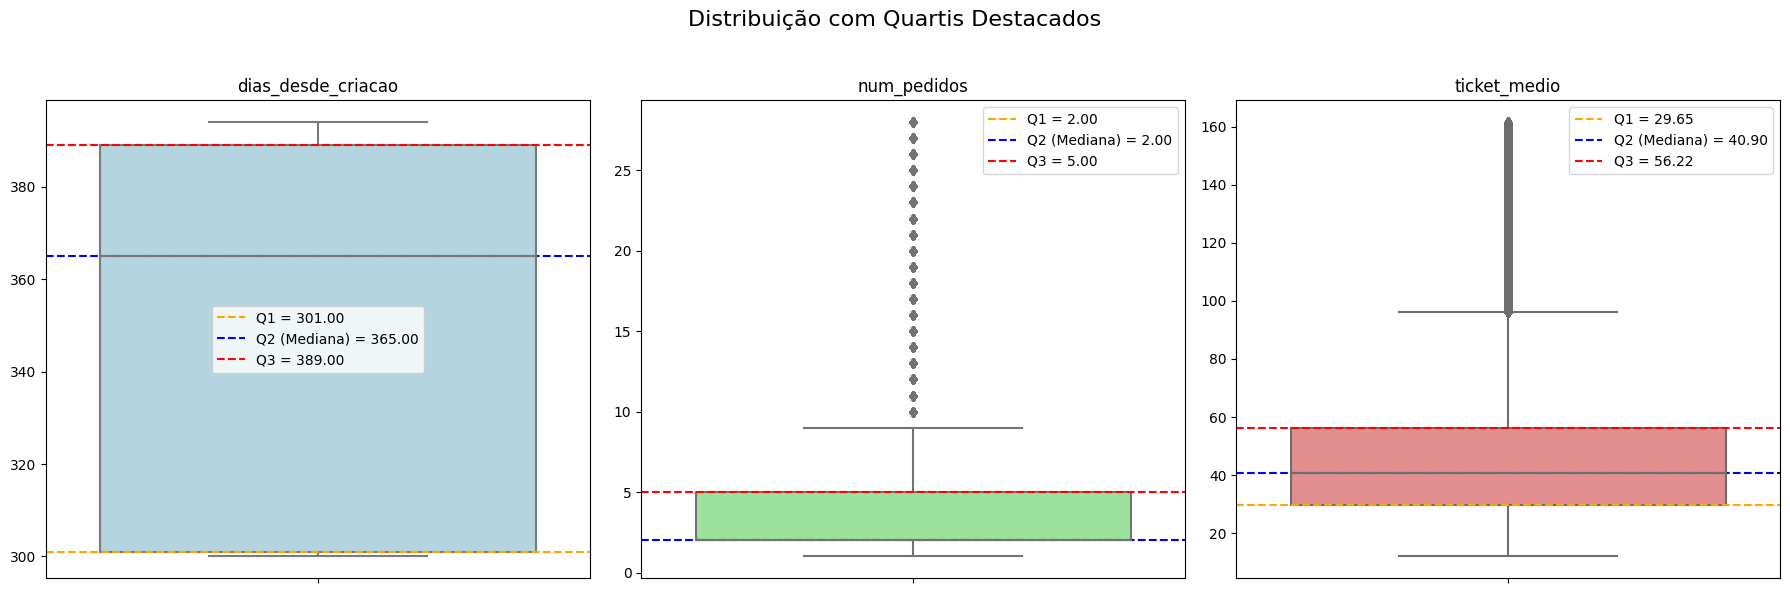

In [0]:
#entendimento do grafico de quartis para segmentação
# Criar figura com 3 subgráficos
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Distribuição com Quartis Destacados", fontsize=16)

# Função auxiliar para desenhar boxplot com linhas de quartis
def plot_boxplot(ax, coluna, cor):
    sns.boxplot(y=df_sem_outliers[coluna], ax=ax, color=cor)
    q1 = df_sem_outliers[coluna].quantile(0.25)
    q2 = df_sem_outliers[coluna].quantile(0.50)
    q3 = df_sem_outliers[coluna].quantile(0.75)

    ax.axhline(q1, color="orange", linestyle="--", label=f"Q1 = {q1:.2f}")
    ax.axhline(q2, color="blue", linestyle="--", label=f"Q2 (Mediana) = {q2:.2f}")
    ax.axhline(q3, color="red", linestyle="--", label=f"Q3 = {q3:.2f}")

    ax.set_title(f"{coluna}")
    ax.set_ylabel("")
    ax.legend()

# Plot para cada variável
plot_boxplot(axs[0], "dias_desde_criacao", "lightblue")
plot_boxplot(axs[1], "num_pedidos", "lightgreen")
plot_boxplot(axs[2], "ticket_medio", "lightcoral")

# Ajustar layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

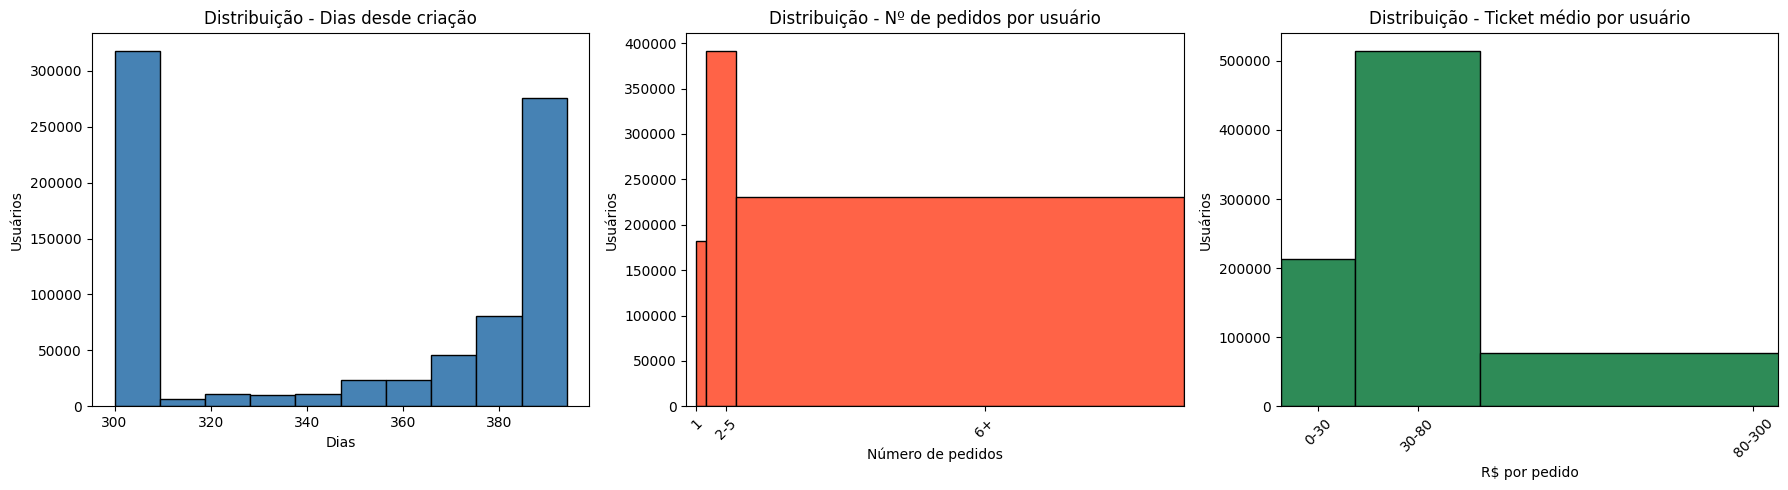

In [0]:
#testes de distribuição para segmentação

# Definir bins personalizados
bins_pedidos = [ 1, 2, 5,  50]
bins_ticket = [0, 30,  80, 300]

# Criar a figura com 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Histograma: dias desde criação
axs[0].hist(df_pandas["dias_desde_criacao"], bins=10, color="steelblue", edgecolor="black")
axs[0].set_title("Distribuição - Dias desde criação")
axs[0].set_xlabel("Dias")
axs[0].set_ylabel("Usuários")


# Histograma: número de pedidos
axs[1].hist(df_pandas["num_pedidos"], bins=bins_pedidos, color="tomato", edgecolor="black")
axs[1].set_title("Distribuição - Nº de pedidos por usuário")
axs[1].set_xlabel("Número de pedidos")
axs[1].set_ylabel("Usuários")
axs[1].set_xlim(0, 50)
ticks = [1, 4,  30]
labels = ["1", "2-5", "6+"]
axs[1].set_xticks(ticks)
axs[1].set_xticklabels(labels, rotation=45)


# Histograma: ticket médio
axs[2].hist(df_pandas["ticket_medio"], bins=bins_ticket, color="seagreen", edgecolor="black")
axs[2].set_title("Distribuição - Ticket médio por usuário")
axs[2].set_xlabel("R$ por pedido")
axs[2].set_ylabel("Usuários")
axs[2].tick_params(axis='x', rotation=45)
axs[2].set_xlim(0, 200)
centros_bins = [(bins_ticket[i] + bins_ticket[i+1]) / 2 for i in range(len(bins_ticket)-1)]
labels_bins = [f"{bins_ticket[i]}-{bins_ticket[i+1]}" for i in range(len(bins_ticket)-1)]

axs[2].set_xticks(centros_bins)
axs[2].set_xticklabels(labels_bins, rotation=45)

plt.tight_layout()
plt.show()

-Segmento por dias desde a criação não faz sentido pois foi realizada uma amostragem de cientes de 300 a 400 dias de criação 

In [0]:
#criar segmento de frenquencia
df_segmento_user = df_segmento_user.withColumn(
    "segmento_frequencia",
    when(col("num_pedidos") == 1, "1pedido")
    .when((col("num_pedidos") >= 2) & (col("num_pedidos") <= 5), "recorrente")
    .when(col("num_pedidos") > 5, "fiel")
    .otherwise("inativo")
)
display(df_segmento_user.limit(10))

customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio,segmento_frequencia
a2834a38a9876cf74e016524dd2e8c1f010ee12b2b684d58c40ab11eef19b6eb,pt-br,2018-01-14T21:40:02.141Z,true,ADRIELLY,59,231330577,382,16,46.61,fiel
fc3b69d0454f1ec8c1d196f0d4e9a7cc1409dbc87339a89c0725ec9c054a4765,pt-br,2018-01-04T02:01:17.478Z,true,ANA,91,533597575,392,1,40.5,1pedido
0ce03c2b567f34f421372f0a8b70c6bfd04308d134d52b4436682b304f6d7dd8,pt-br,2018-01-04T14:12:16.843Z,true,MARLOS,18,724199206,392,2,38.48,recorrente
41e1051728eba13341136d67d0757f8d8cc44b2a405b718a8c5efba2c093b2c0,pt-br,2018-01-07T03:47:15.554Z,true,PAULA,62,347597883,389,5,41.16,recorrente
7c2c4d1fe3ce743583c15365efb8ee4ab90d92b5768ffa18b6bc659f3f86c953,pt-br,2018-03-18T20:57:06.301Z,true,REBECCA,32,454530554,319,4,36.43,recorrente
8e7c1dcb64edf95c935147f6d560cb068c44714cb1b21b287f1f433ae7b0b04e,pt-br,2018-01-10T22:17:08.160Z,true,HELTON,13,719366842,386,3,34.22,recorrente
7823d4cf4150c5daeae0bd799206852fc123bdef0cf5d1639c8cb568d73e8c83,pt-br,2018-04-06T00:16:20.935Z,true,WENDER,76,543232158,300,12,27.44,fiel
77e6a36569f6c8f357a661ef59b7854c1701e538ceb5a3a7821dd44797944e0c,pt-br,2018-01-27T20:00:11.176Z,true,MICHELLE,90,806008944,369,11,53.36,fiel
d5de3aa126ae18fd98c65fd544548cc926b36caeb8309a213631d86901bd6074,pt-br,2018-01-08T22:19:15.852Z,true,KELLY,72,47158438,388,4,19.69,recorrente
e8cc60860e09c0bb19610b06ced69c973eb83982cfc98e397ce65cba92f70928,pt-br,2018-04-05T14:49:18.165Z,true,NUNO,46,816135924,301,14,36.71,fiel


In [0]:
# criar segmento por ticket
df_segmento_user = df_segmento_user.withColumn(
    "segmento_ticket",
    when(col("ticket_medio") <= 30, "baixo")
    .when((col("ticket_medio") > 30) & (col("ticket_medio") <= 80), "medio")
    .otherwise("alto")
)
display(df_segmento_user.limit(10))

customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio,segmento_frequencia,segmento_ticket
a2834a38a9876cf74e016524dd2e8c1f010ee12b2b684d58c40ab11eef19b6eb,pt-br,2018-01-14T21:40:02.141Z,true,ADRIELLY,59,231330577,382,16,46.61,fiel,medio
fc3b69d0454f1ec8c1d196f0d4e9a7cc1409dbc87339a89c0725ec9c054a4765,pt-br,2018-01-04T02:01:17.478Z,true,ANA,91,533597575,392,1,40.5,1pedido,medio
0ce03c2b567f34f421372f0a8b70c6bfd04308d134d52b4436682b304f6d7dd8,pt-br,2018-01-04T14:12:16.843Z,true,MARLOS,18,724199206,392,2,38.48,recorrente,medio
41e1051728eba13341136d67d0757f8d8cc44b2a405b718a8c5efba2c093b2c0,pt-br,2018-01-07T03:47:15.554Z,true,PAULA,62,347597883,389,5,41.16,recorrente,medio
7c2c4d1fe3ce743583c15365efb8ee4ab90d92b5768ffa18b6bc659f3f86c953,pt-br,2018-03-18T20:57:06.301Z,true,REBECCA,32,454530554,319,4,36.43,recorrente,medio
8e7c1dcb64edf95c935147f6d560cb068c44714cb1b21b287f1f433ae7b0b04e,pt-br,2018-01-10T22:17:08.160Z,true,HELTON,13,719366842,386,3,34.22,recorrente,medio
7823d4cf4150c5daeae0bd799206852fc123bdef0cf5d1639c8cb568d73e8c83,pt-br,2018-04-06T00:16:20.935Z,true,WENDER,76,543232158,300,12,27.44,fiel,baixo
77e6a36569f6c8f357a661ef59b7854c1701e538ceb5a3a7821dd44797944e0c,pt-br,2018-01-27T20:00:11.176Z,true,MICHELLE,90,806008944,369,11,53.36,fiel,medio
d5de3aa126ae18fd98c65fd544548cc926b36caeb8309a213631d86901bd6074,pt-br,2018-01-08T22:19:15.852Z,true,KELLY,72,47158438,388,4,19.69,recorrente,baixo
e8cc60860e09c0bb19610b06ced69c973eb83982cfc98e397ce65cba92f70928,pt-br,2018-04-05T14:49:18.165Z,true,NUNO,46,816135924,301,14,36.71,fiel,medio


In [0]:
# criar segmento por tempo de conta
df_segmento_user = df_segmento_user.withColumn(
    "segmento_tempo_conta",
    when(col("dias_desde_criacao") <= 45, "novo")
    .when((col("dias_desde_criacao") > 45) & (col("dias_desde_criacao") <= 90), "medio")
    .otherwise("antigo")
)
display(df_segmento_user.limit(10))

customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio,segmento_frequencia,segmento_ticket,segmento_tempo_conta
a2834a38a9876cf74e016524dd2e8c1f010ee12b2b684d58c40ab11eef19b6eb,pt-br,2018-01-14T21:40:02.141Z,true,ADRIELLY,59,231330577,382,16,46.61,fiel,medio,antigo
fc3b69d0454f1ec8c1d196f0d4e9a7cc1409dbc87339a89c0725ec9c054a4765,pt-br,2018-01-04T02:01:17.478Z,true,ANA,91,533597575,392,1,40.5,1pedido,medio,antigo
0ce03c2b567f34f421372f0a8b70c6bfd04308d134d52b4436682b304f6d7dd8,pt-br,2018-01-04T14:12:16.843Z,true,MARLOS,18,724199206,392,2,38.48,recorrente,medio,antigo
41e1051728eba13341136d67d0757f8d8cc44b2a405b718a8c5efba2c093b2c0,pt-br,2018-01-07T03:47:15.554Z,true,PAULA,62,347597883,389,5,41.16,recorrente,medio,antigo
7c2c4d1fe3ce743583c15365efb8ee4ab90d92b5768ffa18b6bc659f3f86c953,pt-br,2018-03-18T20:57:06.301Z,true,REBECCA,32,454530554,319,4,36.43,recorrente,medio,antigo
8e7c1dcb64edf95c935147f6d560cb068c44714cb1b21b287f1f433ae7b0b04e,pt-br,2018-01-10T22:17:08.160Z,true,HELTON,13,719366842,386,3,34.22,recorrente,medio,antigo
7823d4cf4150c5daeae0bd799206852fc123bdef0cf5d1639c8cb568d73e8c83,pt-br,2018-04-06T00:16:20.935Z,true,WENDER,76,543232158,300,12,27.44,fiel,baixo,antigo
77e6a36569f6c8f357a661ef59b7854c1701e538ceb5a3a7821dd44797944e0c,pt-br,2018-01-27T20:00:11.176Z,true,MICHELLE,90,806008944,369,11,53.36,fiel,medio,antigo
d5de3aa126ae18fd98c65fd544548cc926b36caeb8309a213631d86901bd6074,pt-br,2018-01-08T22:19:15.852Z,true,KELLY,72,47158438,388,4,19.69,recorrente,baixo,antigo
e8cc60860e09c0bb19610b06ced69c973eb83982cfc98e397ce65cba92f70928,pt-br,2018-04-05T14:49:18.165Z,true,NUNO,46,816135924,301,14,36.71,fiel,medio,antigo


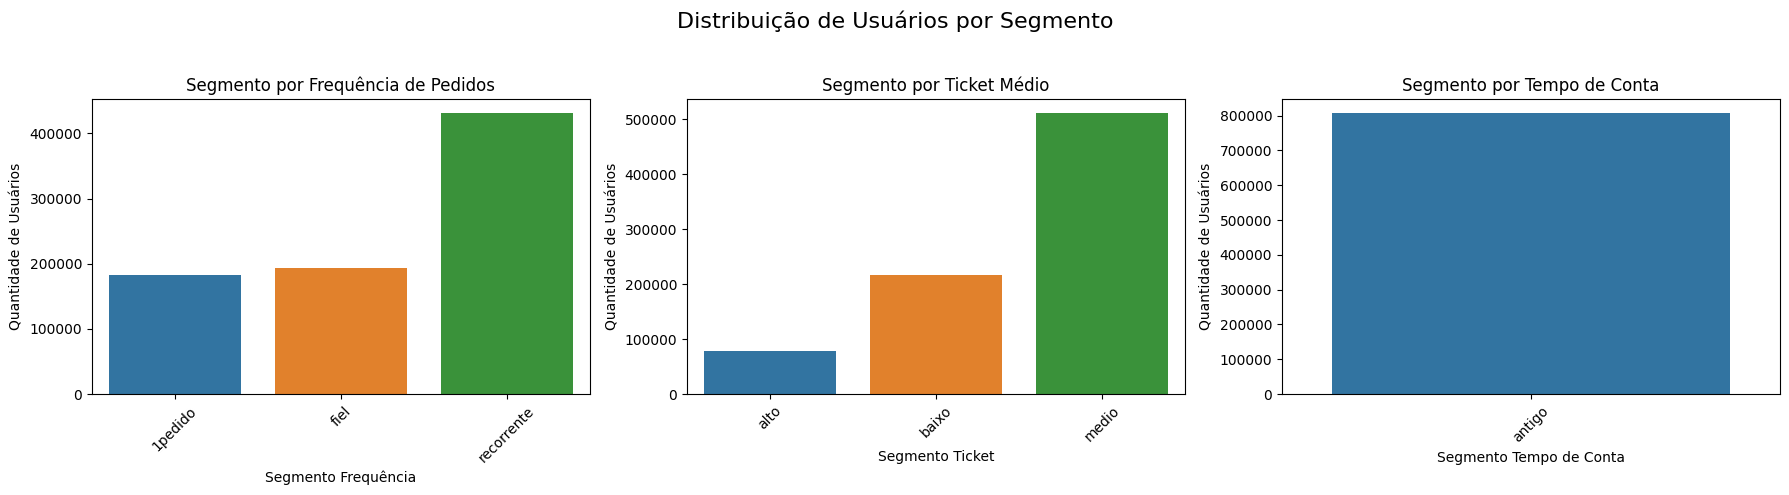

In [0]:
#verificar como ficou a segmentação

# Selecionar as colunas desejadas
df_plot = df_segmento_user.select("segmento_frequencia", "segmento_ticket", "segmento_tempo_conta")

# Coletar para Pandas
df_pandas = df_plot.toPandas()


# Configurações gerais
plt.figure(figsize=(18, 5))
plt.suptitle("Distribuição de Usuários por Segmento", fontsize=16)

# Gráfico 1: Frequência
plt.subplot(1, 3, 1)
sns.countplot(data=df_pandas, x="segmento_frequencia", order=sorted(df_pandas["segmento_frequencia"].unique()))
plt.title("Segmento por Frequência de Pedidos")
plt.xlabel("Segmento Frequência")
plt.ylabel("Quantidade de Usuários")
plt.xticks(rotation=45)

# Gráfico 2: Ticket Médio
plt.subplot(1, 3, 2)
sns.countplot(data=df_pandas, x="segmento_ticket", order=sorted(df_pandas["segmento_ticket"].unique()))
plt.title("Segmento por Ticket Médio")
plt.xlabel("Segmento Ticket")
plt.ylabel("Quantidade de Usuários")
plt.xticks(rotation=45)

# Gráfico 3: Tempo de Conta
plt.subplot(1, 3, 3)
sns.countplot(data=df_pandas, x="segmento_tempo_conta", order=sorted(df_pandas["segmento_tempo_conta"].unique()))
plt.title("Segmento por Tempo de Conta")
plt.xlabel("Segmento Tempo de Conta")
plt.ylabel("Quantidade de Usuários")
plt.xticks(rotation=45)

# Ajuste do layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

segmento por tempo de conta não faz sentido sera removido

In [0]:
#remover segmento por tempo de conta
df_segmento_user = df_segmento_user.drop(df_segmento_user.segmento_tempo_conta)

In [0]:
#df com os DDDs e seus respectivos estados
df_estado  = spark.read.format("delta").load(base_path+"estado")
df_estado.limit(1).show()

+-----+---+
|SG_UF|DDD|
+-----+---+
|   RO| 69|
+-----+---+



In [0]:
#inner entre base segmento e estados
df_users_segmented_uf = df_segmento_user.join(
    df_estado,
    df_segmento_user.customer_phone_area == df_estado.DDD,
    how="inner"
)
df_users_segmented_uf = df_users_segmented_uf.drop(df_estado.DDD)

display(df_users_segmented_uf.limit(10))

customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio,segmento_frequencia,segmento_ticket,SG_UF
aa4a7ef1e1b6dc399fe202001dfc781896975da6cc38872af9b54ae3d2f3e371,pt-br,2018-01-02T22:01:27.965Z,true,MARÍLIA,98,263641038,394,6,27.95,fiel,baixo,MA
c50bc8fa0a6e2aff66ed6334fbed10d560405e7541f55de3e3710b057ae86c93,pt-br,2018-04-06T00:39:11.036Z,true,PATRICIA,89,654154722,300,10,40.22,fiel,medio,PI
8289e89843986066ea5350dbcba571c1674db6773a932ecb0e66311fcbb3c978,pt-br,2018-01-03T14:40:07.232Z,true,PATRICIA,87,997499072,393,82,49.41,fiel,medio,PE
5ac6460d50b52358e54674f13ced0e4c92c7157650a47f153458e064d35397f7,pt-br,2018-04-05T18:03:12.032Z,true,NADIA,93,503411630,301,7,49.14,fiel,medio,PA
cf9f2ff9f7a0d44ccb401687160b278aa9fa487cdbf0b181d3c78a39ecaec710,pt-br,2018-02-14T22:53:24.947Z,true,RITA,65,650942741,351,1,62.0,1pedido,medio,MT
d389552c579735587b6bf3bdbe8ef0896846a41f5f754cbe3613d8a2755689b3,pt-br,2018-01-03T14:53:20.782Z,true,ETIENE,51,474670553,393,7,19.03,fiel,baixo,RS
eabd6a6f6aa7a58dc2f6612fb060aa4d050a926fa3d60803727f8f30a7350342,pt-br,2018-01-02T22:03:53.925Z,true,Fernanda,35,616862421,394,33,94.85,fiel,alto,MG
e1ae7dc0c3f9ed4045d8a5c5b1a07125f96037e184a07e2303da0cc782e7fa12,pt-br,2018-01-07T16:10:28.458Z,true,MATEUS,75,250017973,389,34,44.18,fiel,medio,BA
4bb1bb86acdcf9e8b6ef4b76b6cf4a470cd5162885a56cb053a0bbbf85c4fe36,pt-br,2018-02-01T00:27:37.685Z,true,FILIPE,99,499831827,364,6,66.0,fiel,medio,MA
30f8b1f987be2613cdfc0b4634dd9ae9b2fc1aa3072c48583d2b9f5f41e86816,pt-br,2018-04-06T03:16:01.368Z,true,JESSY,64,780959097,300,7,20.1,fiel,baixo,GO


In [0]:
#preparação para graffico
df_uf_counts = df_users_segmented_uf.groupBy("SG_UF").count()
df_uf_counts_pd = df_uf_counts.toPandas().sort_values("count", ascending=False)

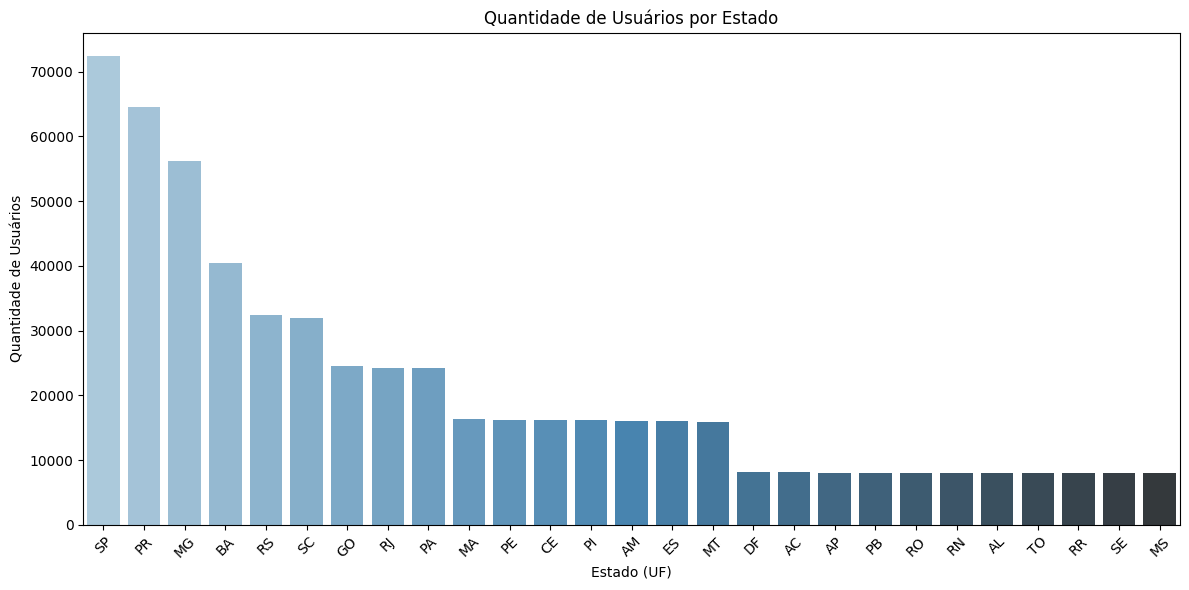

In [0]:
#grafico qtde de usuarios por estado
plt.figure(figsize=(12, 6))
sns.barplot(data=df_uf_counts_pd, x="SG_UF", y="count", palette="Blues_d")

plt.title("Quantidade de Usuários por Estado")
plt.xlabel("Estado (UF)")
plt.ylabel("Quantidade de Usuários")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
#join para ter o dados do teste AB
df_analise_segmento = df_users_segmented_uf.join(df_teste, on="customer_id",how="inner")
# Adiciona a coluna binária "retido"
df_analise_segmento = df_analise_segmento.withColumn("retido", when(col("num_pedidos") >= 2, 1).otherwise(0))

display(df_analise_segmento.limit(5))

customer_id,language,created_at,active,customer_name,customer_phone_area,customer_phone_number,dias_desde_criacao,num_pedidos,ticket_medio,segmento_frequencia,segmento_ticket,SG_UF,is_target,retido
aa4a7ef1e1b6dc399fe202001dfc781896975da6cc38872af9b54ae3d2f3e371,pt-br,2018-01-02T22:01:27.965Z,true,MARÍLIA,98,263641038,394,6,27.95,fiel,baixo,MA,target,1
c50bc8fa0a6e2aff66ed6334fbed10d560405e7541f55de3e3710b057ae86c93,pt-br,2018-04-06T00:39:11.036Z,true,PATRICIA,89,654154722,300,10,40.22,fiel,medio,PI,target,1
8289e89843986066ea5350dbcba571c1674db6773a932ecb0e66311fcbb3c978,pt-br,2018-01-03T14:40:07.232Z,true,PATRICIA,87,997499072,393,82,49.41,fiel,medio,PE,target,1
5ac6460d50b52358e54674f13ced0e4c92c7157650a47f153458e064d35397f7,pt-br,2018-04-05T18:03:12.032Z,true,NADIA,93,503411630,301,7,49.14,fiel,medio,PA,target,1
cf9f2ff9f7a0d44ccb401687160b278aa9fa487cdbf0b181d3c78a39ecaec710,pt-br,2018-02-14T22:53:24.947Z,true,RITA,65,650942741,351,1,62.0,1pedido,medio,MT,control,0


In [0]:
# 4. Análise por segmento de frequência
df_agg_freq = (
    df_analise_segmento.groupBy("is_target", "segmento_frequencia")
    .agg(
        count("*").alias("usuarios"),
        avg("num_pedidos").alias("media_pedidos"),
        avg("ticket_medio").alias("media_ticket")
    )
    .orderBy("segmento_frequencia", "is_target")
)

# 5. Análise por segmento de ticket
df_agg_ticket = (
    df_analise_segmento.groupBy("is_target", "segmento_ticket")
    .agg(
        count("*").alias("usuarios"),
        avg("num_pedidos").alias("media_pedidos"),
        avg("ticket_medio").alias("media_ticket")
    )
    .orderBy("segmento_ticket", "is_target")
)

# 6. Análise por estado 
df_agg_estado = (
    df_analise_segmento.groupBy("is_target", "SG_UF")
    .agg(
        count("*").alias("usuarios"),
        avg("num_pedidos").alias("media_pedidos"),
        avg("ticket_medio").alias("media_ticket")
    )
    .orderBy("SG_UF", "is_target")
)

# 7. Exibir os resultados
df_agg_freq.show()
df_agg_ticket.show()
df_agg_estado.show()

+---------+-------------------+--------+------------------+------------------+
|is_target|segmento_frequencia|usuarios|     media_pedidos|      media_ticket|
+---------+-------------------+--------+------------------+------------------+
|  control|            1pedido|   65070|               1.0| 48.04184170892923|
|   target|            1pedido|   64818|               1.0| 48.04817782097602|
|  control|               fiel|   55039|11.712985337669652| 47.85568887516124|
|   target|               fiel|   81873|11.757368118915881|  47.7877796098835|
|  control|         recorrente|  135978|2.7323905337628145|47.634256203211805|
|   target|         recorrente|  169479|2.8845933714501504| 47.74198036335087|
+---------+-------------------+--------+------------------+------------------+

+---------+---------------+--------+------------------+------------------+
|is_target|segmento_ticket|usuarios|     media_pedidos|      media_ticket|
+---------+---------------+--------+------------------+----

In [0]:
df_retencao_ticket = (
    df_analise_segmento.groupBy("is_target", "segmento_ticket")
    .agg(
        count("*").alias("total_usuarios"),
        sum("retido").alias("usuarios_retidos")
    )
    .withColumn("taxa_retencao", col("usuarios_retidos") / col("total_usuarios"))
    .orderBy("segmento_ticket", "is_target")
)
display(df_retencao_ticket)

is_target,segmento_ticket,total_usuarios,usuarios_retidos,taxa_retencao
control,alto,25008,18025,0.7207693538067819
target,alto,30468,23615,0.7750754890376789
control,baixo,69767,49915,0.7154528645348087
target,baixo,84399,64417,0.763243640327492
control,medio,161312,123077,0.7629748561793295
target,medio,201303,163320,0.8113142874174751


/home/spark-a4e21d08-09b7-4288-8d7e-a1/.ipykernel/2839/command-8657600291717930-946060459:22: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, 0)


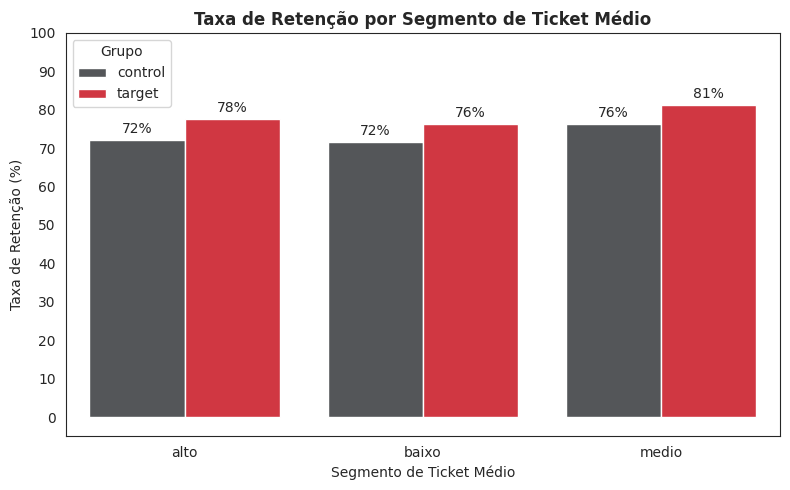

In [0]:
import seaborn as sns
df_retencao_ticket_plot = df_retencao_ticket.toPandas()
plt.figure(figsize=(8,5))
sns.set_style("white")

barplot = sns.barplot(
    data=df_retencao_ticket_plot,
    x="segmento_ticket",
    y="taxa_retencao",
    hue="is_target",
    palette={"control":"#53565A", "target": "#EA1D2C"}
)

# Adicionando rótulos com 2 casas decimais
for container in barplot.containers:
    barplot.bar_label(container, labels=[f"{v.get_height() * 100:.0f}%" for v in container], fontsize=10, label_type='edge', padding=3)

# Ajustes visuais
plt.title("Taxa de Retenção por Segmento de Ticket Médio", fontsize=12, weight='bold')
plt.ylabel("Taxa de Retenção (%)")
plt.xlabel("Segmento de Ticket Médio")
plt.ylim(0, 0)
plt.legend(title="Grupo")

# Formatar o eixo Y 
barplot.set_yticks([i/10 for i in range(0, 11)])
barplot.set_yticklabels([f"{int(i*100)}" for i in barplot.get_yticks()])

plt.tight_layout()
plt.show()

In [0]:
df_retencao_estado = (
    df_analise_segmento.groupBy("is_target", "SG_UF")
    .agg(
        count("*").alias("total_usuarios"),
        sum("retido").alias("usuarios_retidos")
    )
    .withColumn("taxa_retencao", col("usuarios_retidos") / col("total_usuarios"))
    .orderBy("SG_UF", "is_target")
)
display(df_retencao_estado)

is_target,SG_UF,total_usuarios,usuarios_retidos,taxa_retencao
control,AC,3685,2836,0.769606512890095
target,AC,4454,3500,0.7858105074090705
control,AL,3607,2656,0.7363459939007485
target,AL,4388,3452,0.7866909753874203
control,AM,7061,5308,0.7517348817447953
target,AM,9014,7122,0.7901042822276458
control,AP,3630,2716,0.7482093663911846
target,AP,4437,3543,0.7985125084516566
control,BA,18190,13552,0.7450247388675096
target,BA,22322,17730,0.7942836663381417


/home/spark-a4e21d08-09b7-4288-8d7e-a1/.ipykernel/2839/command-8657600291717932-855757026:21: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, 0)


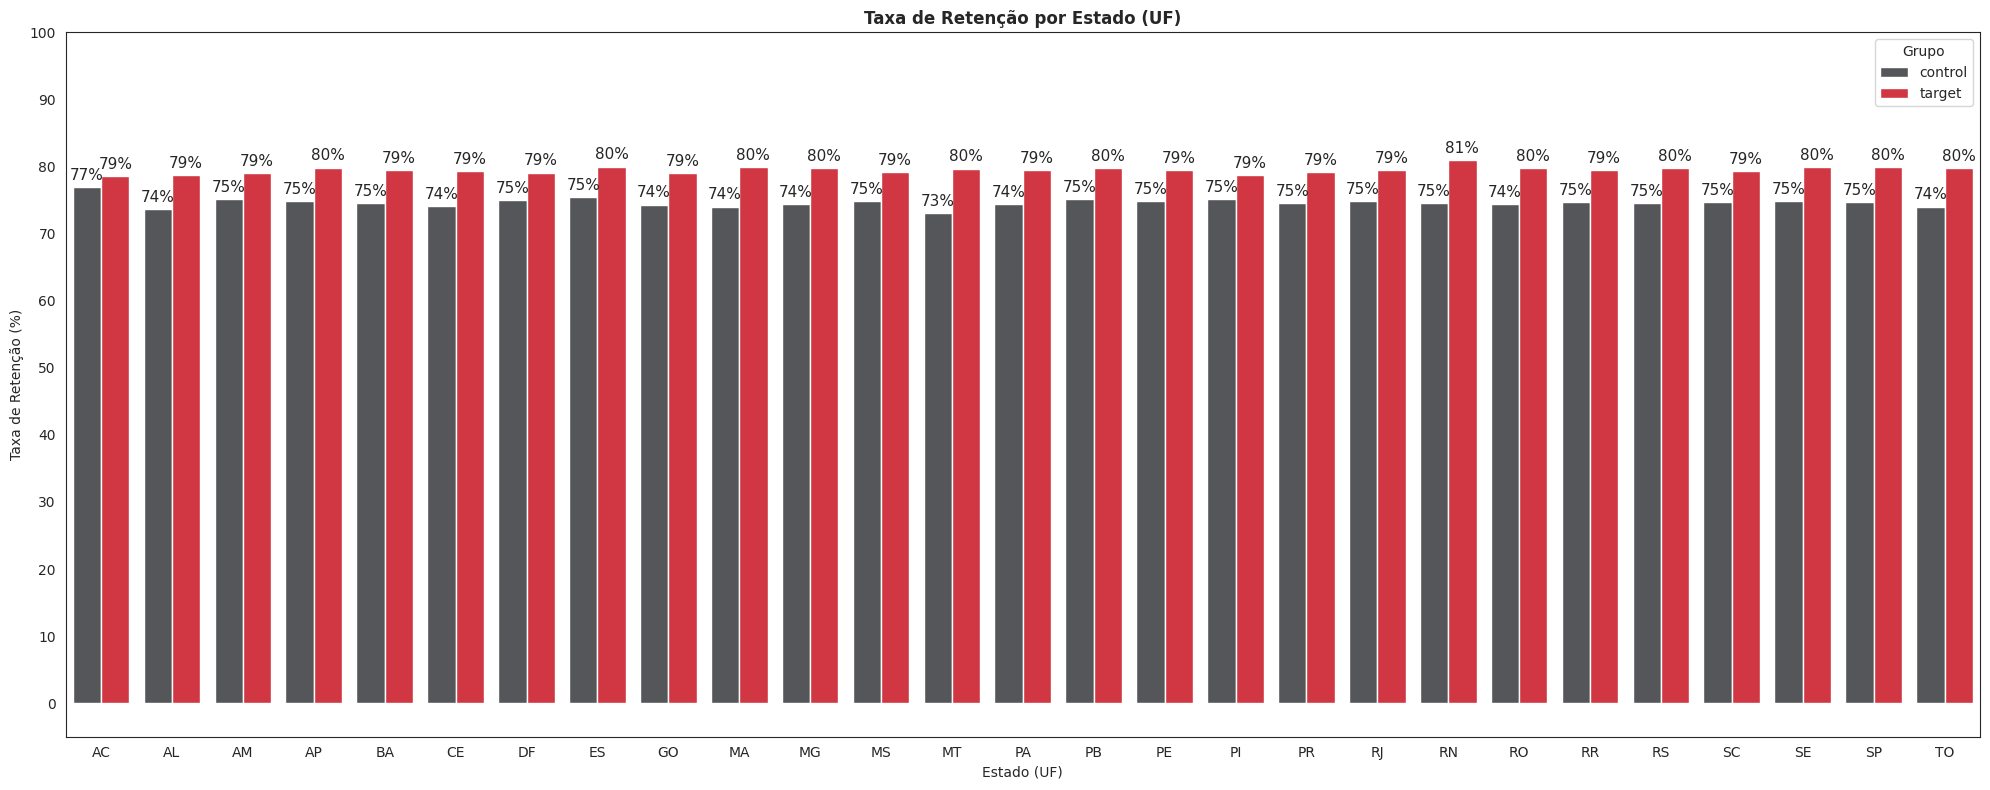

In [0]:
df_retencao_estado_plot = df_retencao_estado.toPandas()
plt.figure(figsize=(20,8))
sns.set_style("white")

barplot = sns.barplot(
    data=df_retencao_estado_plot,
    x="SG_UF",
    y="taxa_retencao",
    hue="is_target",
    palette={"control":"#53565A", "target": "#EA1D2C"}
)

# Adicionando rótulos com 2 casas decimais
for container in barplot.containers:
    barplot.bar_label(container, labels=[f"{v.get_height() * 100:.0f}%" for v in container], fontsize=11, label_type='edge', padding=3)

# Ajustes visuais
plt.title("Taxa de Retenção por Estado (UF)", fontsize=12, weight='bold')
plt.ylabel("Taxa de Retenção (%)")
plt.xlabel("Estado (UF)")
plt.ylim(0, 0)
plt.legend(title="Grupo")

# Formatar o eixo Y 
barplot.set_yticks([i/10 for i in range(0, 11)])
barplot.set_yticklabels([f"{int(i*100)}" for i in barplot.get_yticks()])

plt.tight_layout()
plt.show()


In [0]:
#  Agregar dados de pedidos por cliente e plataforma
df_pedido_agg = (
    df_pedido.groupBy("customer_id", "origin_platform")
    .agg(
        count("order_id").alias("num_pedidos"),
        avg("order_total_amount").alias("ticket_medio")
    )
)
#  Criar variável retido com base na lógica do case
df_pedido_agg = df_pedido_agg.withColumn(
    "retido",
    when(col("num_pedidos") > 1, 1).otherwise(0)
)

#  Juntar com grupo A/B
df_avaliacao = (
    df_pedido_agg.join(
        df_teste,
        on="customer_id",
        how="inner"
    )
)

df_avaliacao.show(10)

+--------------------+---------------+-----------+------------------+------+---------+
|         customer_id|origin_platform|num_pedidos|      ticket_medio|retido|is_target|
+--------------------+---------------+-----------+------------------+------+---------+
|90b21ae861e2e5305...|            IOS|          1|              29.9|     0|  control|
|2aeebac9b2e8a959e...|            IOS|          1|              24.9|     0|  control|
|c4ba5dc6835b70ea2...|            IOS|          8|49.388749999999995|     1|   target|
|cf9f2ff9f7a0d44cc...|            IOS|          1|              62.0|     0|  control|
|040aa9668a39e9149...|            IOS|          3| 96.66666666666667|     1|   target|
|665c68e58e08568ef...|        ANDROID|          4|              20.9|     1|  control|
|9ed2aa1f8587f5bf0...|            IOS|          2|57.400000000000006|     1|   target|
|4997130957c144f4a...|        ANDROID|         17| 46.21176470588235|     1|   target|
|9f48d926e027fe2a3...|            IOS|     

In [0]:
# 4. Agregar por plataforma e grupo
df_resultado = (
    df_avaliacao.groupBy("origin_platform", "is_target")
    .agg(
        count("*").alias("total_usuarios"),
        sum("retido").alias("usuarios_retidos"),
        avg("ticket_medio").alias("media_ticket"),
        avg("num_pedidos").alias("media_pedidos")
    )
    .withColumn("taxa_retencao", col("usuarios_retidos") / col("total_usuarios"))
    .orderBy("origin_platform", "is_target")
)

#remover linha null
df_resultado = df_resultado.na.drop()

display(df_resultado)

origin_platform,is_target,total_usuarios,usuarios_retidos,media_ticket,media_pedidos,taxa_retencao
ANDROID,control,160257,117305,43.75063141030718,3.8150907604660014,0.7319805063117367
ANDROID,target,199259,154719,43.36057076578022,4.301732920470343,0.7764718281231965
DESKTOP,control,60764,42974,48.00693771302524,3.7391383055756697,0.7072279639260088
DESKTOP,target,75870,56461,47.95517966170673,4.200171345722947,0.7441808356399103
IOS,control,154441,117221,52.79002047990059,4.3713197920241385,0.7590018194650384
IOS,target,193998,156030,52.800985390876534,4.871132692089609,0.8042866421303312
WINDOWS_PHONE,control,3604,2444,40.09514453571282,3.291620421753607,0.6781354051054383
WINDOWS_PHONE,target,4524,3307,41.07414345130244,3.520999115826702,0.7309902740937224


/home/spark-a4e21d08-09b7-4288-8d7e-a1/.ipykernel/2839/command-8787584333253324-2716016978:21: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, 0)


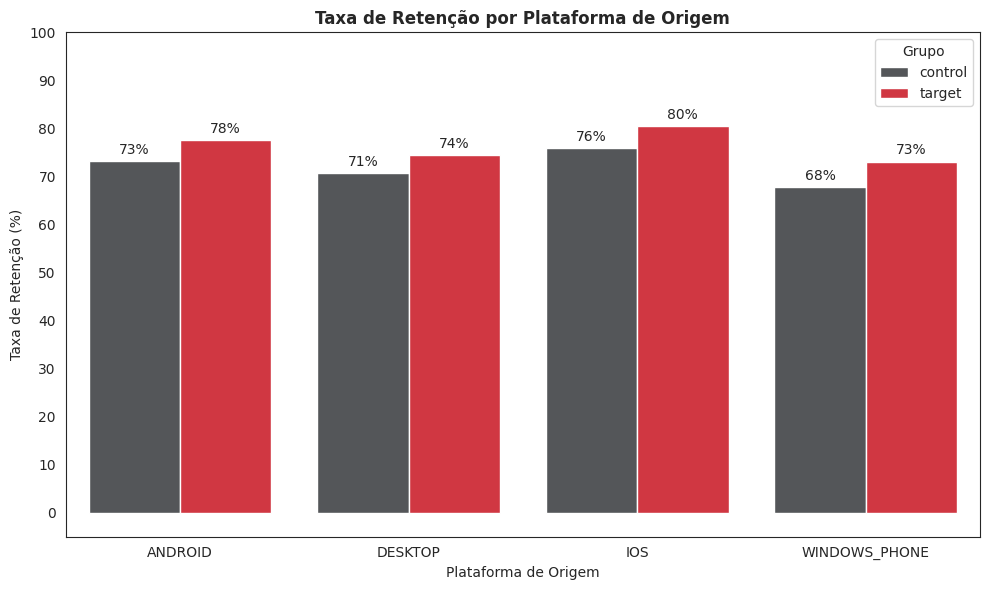

In [0]:
df_resultado_plot = df_resultado.toPandas()
plt.figure(figsize=(10,6))
sns.set_style("white")

barplot = sns.barplot(
    data=df_resultado_plot,
    x="origin_platform",
    y="taxa_retencao",
    hue="is_target",
    palette={"control":"#53565A", "target": "#EA1D2C"}
)

# Adicionando rótulos com 2 casas decimais
for container in barplot.containers:
    barplot.bar_label(container, labels=[f"{v.get_height() * 100:.0f}%" for v in container], fontsize=10, label_type='edge', padding=3)

# Ajustes visuais
plt.title("Taxa de Retenção por Plataforma de Origem", fontsize=12, weight='bold')
plt.ylabel("Taxa de Retenção (%)")
plt.xlabel("Plataforma de Origem")
plt.ylim(0, 0)
plt.legend(title="Grupo")

# Formatar o eixo Y 
barplot.set_yticks([i/10 for i in range(0, 11)])
barplot.set_yticklabels([f"{int(i*100)}" for i in barplot.get_yticks()])

plt.tight_layout()
plt.show()